In [2]:
%pip install emot

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\del-f\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from emot.emo_unicode import UNICODE_EMOJI, EMOTICONS_EMO
import pickle

In [4]:
#Read csv file and name columns
data = pd.read_csv("../Data/Twitter.csv", header=None, encoding='latin-1')
data.columns = ['sentiment', 'id', 'date', 'query', 'user', 'tweet']

data.head()

,sentiment,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
#Drop the column 'query', as it only contains 'NO_QUERY'
data = data.drop(columns= 'query')

#Replace the 4 for a positive sentiment with a 1 for easier understanding (there are no numbers between 0 and 4)
data['sentiment'] = data['sentiment'].replace(4, 1)
#0 = negative, 1 = positive

data.head()

,sentiment,id,date,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
#Convert Date and time column into datetime format (By stripping day, month, year and time manually as strings and passing them into datetime function)
data['date_new'] = data['date'].str[8:10] + "/" + data['date'].str[4:7] + "/" + data['date'].str[24:28] + ", " + data['date'].str[11:19]
data['date_new'] = pd.to_datetime(data['date_new'], format="%d/%b/%Y, %H:%M:%S")

#extract DateTime information from column
data['year'] = pd.DatetimeIndex(data['date_new']).year
data['month'] = pd.DatetimeIndex(data['date_new']).month

#Weekday where 0 = Monday and 6 = Sunday
data['weekday'] = pd.DatetimeIndex(data['date_new']).weekday
data['time'] = pd.DatetimeIndex(data['date_new']).time
data['hour'] = pd.DatetimeIndex(data['date_new']).hour

# Extract Timezones
data['date'] = data['date'].astype('string')
data['timezone'] = data['date'].str[20:23]
data.head()

##sort time into groups
#create list of conditions (time groups)
conditions = [
    (data['hour'] < 4),
    (data['hour'] >= 4) & (data['hour'] < 8),
    (data['hour'] >= 8) & (data['hour'] < 12),
    (data['hour'] >= 12) & (data['hour'] < 16),
    (data['hour'] >= 16) & (data['hour'] < 20),
    (data['hour'] >= 20)
    ]

# create a list of the values we want to assign for each condition
values = ['0-4', '4-8', '8-12', '12-16', '16-20', '20-24']

# create a new column and use np.select to assign values to it using our lists as arguments
data['time_group'] = np.select(conditions, values)

#drop old date column
data.drop(['date', 'timezone'], axis = 1, inplace=True)
data.rename(columns={'date_new': 'date'}, inplace=True)

data.head()

,sentiment,id,user,tweet,date,year,month,weekday,time,hour,time_group
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009,4,0,22:19:45,22,20-24
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,22,20-24
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009,4,0,22:19:53,22,20-24
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24


In [7]:
#Count the number of words per tweet
data['word_count'] = data['tweet'].str.split().str.len()

#Check, if certain special characters occur in a tweet (one-hot encoded)
data['dot_dot_dot'] = data['tweet'].str.contains('\.\.\.')
data['exclamation_mark'] = data['tweet'].str.contains('!')
data['question_mark'] = data['tweet'].str.contains('\?')
data['at_symbol'] = data['tweet'].str.contains('\@')
data['link'] = data['tweet'].str.contains('http')
data['money'] = data['tweet'].str.contains('\$|\€|\£')
data['paragraph_symbol'] = data['tweet'].str.contains('\§')
data['hashtag'] = data['tweet'].str.contains('#')

data.head()

,sentiment,id,user,tweet,date,year,month,weekday,time,hour,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,2009,4,0,22:19:45,22,20-24,19,False,False,False,True,True,False,False,False
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,22,20-24,21,True,True,False,False,False,False,False,False
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,2009,4,0,22:19:53,22,20-24,18,False,False,False,True,False,False,False,False
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24,10,False,False,False,False,False,False,False,False
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,2009,4,0,22:19:57,22,20-24,21,False,False,True,True,False,False,False,False


In [8]:
convert_dict = {'dot_dot_dot': 'int64',
                'exclamation_mark': 'int64',
                'question_mark': 'int64',
                'at_symbol': 'int64',
                'link': 'int64',
                'money': 'int64',
                'paragraph_symbol': 'int64',
                'hashtag': 'int64'
                }
data = data.astype(convert_dict)

In [9]:
#nltk.download('stopwords')
stopword = nltk.corpus.stopwords.words('english') #Create a list of english stopwords from nltk
stopword

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [10]:
stopword_clean = [word.replace("'", "") for word in stopword]

In [11]:
#Define the typical pattern of links ('https://', 'http://', 'www.'), tags ('@') and hashtags ('#')
url_pattern_1 = r'https?://\S+'
url_pattern_2 = r'www\.\S+'
tag_pattern = r'@\S+'
hashtag_pattern = r'#\S+'

#Add a new column for the tokenized tweet and remove all links, tags and hashtags from the tweets
data.insert(4, 'tweet_tokenized', data['tweet'].apply(lambda x: re.sub(url_pattern_1, '', x)))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(url_pattern_2, '', x))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(tag_pattern, '', x))
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: re.sub(hashtag_pattern, '', x))


In [12]:
print(EMOTICONS_EMO)

{':‑)': 'Happy face or smiley', ':-))': 'Very happy', ':-)))': 'Very very Happy face or smiley', ':)': 'Happy face or smiley', ':))': 'Very Happy face or smiley', ':)))': 'Very very Happy face or smiley', ':-]': 'Happy face or smiley', ':]': 'Happy face or smiley', ':-3': 'Happy face smiley', ':3': 'Happy face smiley', ':->': 'Happy face smiley', ':>': 'Happy face smiley', '8-)': 'Happy face smiley', ':o)': 'Happy face smiley', ':-}': 'Happy face smiley', ':}': 'Happy face smiley', ':-)': 'Happy face smiley', ':c)': 'Happy face smiley', ':^)': 'Happy face smiley', '=]': 'Happy face smiley', '=)': 'Happy face smiley', ':‑D': 'Laughing, big grin or laugh with glasses', ':D': 'Laughing, big grin or laugh with glasses', '8‑D': 'Laughing, big grin or laugh with glasses', '8D': 'Laughing, big grin or laugh with glasses', 'X‑D': 'Laughing, big grin or laugh with glasses', 'XD': 'Laughing, big grin or laugh with glasses', '=D': 'Laughing, big grin or laugh with glasses', '=3': 'Laughing, big g

In [13]:
#Handling Emojis
# Function for converting emojis into word
def convert_emoticons(text):
    for emot in EMOTICONS_EMO:
        text = text.replace(emot, "".join(EMOTICONS_EMO[emot].replace(",","").replace(":","").split()))
    return text

# Apply Formula to tweets
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: convert_emoticons(x))
data.head(6)

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","- Awww, that's a bummer. You shoulda got Da...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to s...,2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0
5,0,1467811372,joy_wolf,@Kwesidei not the whole crew,not the whole crew,2009-04-06 22:20:00,2009,4,0,22:20:00,...,20-24,5,0,0,0,1,0,0,0,0


In [14]:
#Remove all punctuation from the tweets
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('[^\w\s]', '')
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('_', '')

#Remove all whitespaces from the beginning or end of the tweets
data['tweet_tokenized'] = data['tweet_tokenized'].str.strip()

#Set all characters to lowercase
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: x.lower())

#Remove all numbers
data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('\d+', '')

data.head()

C:\Users\del-f\AppData\Local\Temp\ipykernel_20248\3552357475.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('[^\w\s]', '')
C:\Users\del-f\AppData\Local\Temp\ipykernel_20248\3552357475.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  data['tweet_tokenized'] = data['tweet_tokenized'].str.replace('\d+', '')


,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats a bummer you shoulda got david car...,2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...,2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....",no its not behaving at all im mad why am i her...,2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


In [15]:
#Tokenize sentences based on non-alphanumeric characters (Leerstelle)
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: tokenize(x))

data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, a, bummer, you, shoulda, got, da...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[is, upset, that, he, cant, update, his, faceb...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[i, dived, many, times, for, the, ball, manage...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[my, whole, body, feels, itchy, and, like, its...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[no, its, not, behaving, at, all, im, mad, why...",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


In [16]:
def remove_stopwords(tokenized_list): #Function to remove all stopword from our list of tokenized tweets
    text = [word for word in tokenized_list if word not in stopword_clean] #Write each word from our tokenized list into a new list, if it is not in the stopword list
    return text

#Create new column with tokenized tweets without stopwords
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: remove_stopwords(x)) 
data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, times, ball, managed, save, rest...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


In [17]:
#nltk.download('wordnet')
wnlemm = nltk.WordNetLemmatizer() 

def lemmatizing(tokenized_text): #Function to lemmatize all words in our tokenized tweets list without stopwords
    text = [wnlemm.lemmatize(word) for word in tokenized_text] #Lemmatize each word in our tokenized list and write it into a new list
    return text

#Create new column with lemmatized tweets from our tokenized tweets without stopwords
data['tweet_tokenized'] = data['tweet_tokenized'].apply(lambda x: lemmatizing(x))
data.head()

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,time_group,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,20-24,19,0,0,0,1,1,0,0,0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,20-24,21,1,1,0,0,0,0,0,0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,20-24,18,0,0,0,1,0,0,0,0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,10,0,0,0,0,0,0,0,0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,20-24,21,0,0,1,1,0,0,0,0


Cleaning

In [18]:
#N-gram vectorizing and tfidf need a list of strings passed to it, so we need to convert our list
data['tweet_tokenized_string'] = data['tweet_tokenized'].apply(lambda x: ' '.join(x)) #Join each word in our list with a space inbetween
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,0,0,0,1,1,0,0,0,awww thats bummer shoulda got david carr third...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,1,1,0,0,0,0,0,0,upset cant update facebook texting might cry r...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,0,0,0,1,0,0,0,0,dived many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,0,0,1,1,0,0,0,0,behaving im mad cant see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[thewdbcom, cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,1,0,0,1,0,0,0,thewdbcom cool hear old walt interview â
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac, ...",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac amaru sh...


In [19]:
words = pd.DataFrame(data.tweet_tokenized_string.str.split(expand=True).stack().value_counts()).reset_index()
words.rename(columns={'index': 'word', 0: 'count'}, inplace=True)

In [20]:
words_to_split = words[words['count'] < 5]
words_to_split

,word,count
51656,clientquot,4
51657,nothinn,4
51658,foulest,4
51659,interception,4
51660,morganampjudybffs,4
...,...,...
408938,jimena,1
408939,funlicous,1
408940,beingohand,1
408941,ustreamive,1


In [21]:
words_to_split_list = words_to_split['word'].tolist()
words_to_split_list

['clientquot',
 'nothinn',
 'foulest',
 'interception',
 'morganampjudybffs',
 'cofffee',
 'towny',
 'dolces',
 'mongoose',
 'quotsomebodyquot',
 'greaattt',
 'seja',
 'irregularly',
 'sunni',
 'pehle',
 'anywa',
 'awwwwwwwwwwwwwwwww',
 'sarkozy',
 'internetconnection',
 'malapit',
 'ilovejb',
 'crossstitch',
 'beastquot',
 'prati',
 'paquot',
 'winkorsmirklt',
 'incidentquot',
 'maaa',
 'immunisation',
 'krugman',
 'lolyeahi',
 'borther',
 'nowhad',
 'quotadam',
 'chiara',
 'showtunes',
 'ejaculate',
 'leechers',
 'kidsll',
 'basia',
 'assload',
 'gratifying',
 'quotpain',
 'schoolcant',
 'sett',
 'arrey',
 'babiesquot',
 'topoptimizercom',
 'rutland',
 'lauging',
 'palak',
 'musle',
 'decider',
 'sorcery',
 'hahathe',
 'fabrice',
 'solat',
 'dyrdeks',
 'saturdaysunday',
 'updatetonguestickingoutcheekyplayfulorblowingaraspberry',
 'witter',
 'giggin',
 'canx',
 'airprt',
 'warnin',
 'dearquot',
 'yayquot',
 'takinq',
 'petfinder',
 'usso',
 'soooory',
 'sungod',
 'sundaymonday',
 'pre

In [22]:
single_use_words = set(words_to_split_list) # Convert your list to a set for faster lookup

def remove_single_use_words(tweet):
    return [word for word in tweet if word not in single_use_words]

data['tweet_tokenized'] = data['tweet_tokenized'].apply(remove_single_use_words)

In [23]:
#N-gram vectorizing and tfidf need a list of strings passed to it, so we need to convert our list
data['tweet_tokenized_string'] = data['tweet_tokenized'].apply(lambda x: ' '.join(x)) #Join each word in our list with a space inbetween
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,0,0,0,1,1,0,0,0,awww thats bummer shoulda got david carr third...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,1,1,0,0,0,0,0,0,upset cant update facebook texting might cry r...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[many, time, ball, managed, save, rest, go, bo...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,0,0,0,1,0,0,0,0,many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,0,0,1,1,0,0,0,0,behaving im mad cant see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,1,0,0,1,0,0,0,cool hear old walt interview â
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac


In [24]:
#Wenn wir wollen, können wir diese Tweets alle herausfiltern (Dafür einfach das False in True umwandeln)
data = data[data['tweet_tokenized_string'].str.contains('[a-zA-Z]')==True] # Alle Tweet herausfiltern die nur nicht normale Buchstaben enthalten

In [25]:
# Index löschen um ihn neu zu nummerieren da sich die Anzahl der Tweets geändert hat
data = data.reset_index()
data = data.drop(columns=['index'])
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,0,0,0,1,1,0,0,0,awww thats bummer shoulda got david carr third...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,1,1,0,0,0,0,0,0,upset cant update facebook texting might cry r...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[many, time, ball, managed, save, rest, go, bo...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,0,0,0,1,0,0,0,0,many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,0,0,0,0,0,0,0,0,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,0,0,1,1,0,0,0,0,behaving im mad cant see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1587561,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,0,0,0,0,0,0,woke school best feeling ever
1587562,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,1,0,0,1,0,0,0,cool hear old walt interview â
1587563,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,0,0,1,0,0,0,0,0,ready mojo makeover ask detail
1587564,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,0,1,0,0,0,0,0,0,happy th birthday boo alll time tupac


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587566 entries, 0 to 1587565
Data columns (total 22 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   sentiment               1587566 non-null  int64         
 1   id                      1587566 non-null  int64         
 2   user                    1587566 non-null  object        
 3   tweet                   1587566 non-null  object        
 4   tweet_tokenized         1587566 non-null  object        
 5   date                    1587566 non-null  datetime64[ns]
 6   year                    1587566 non-null  int64         
 7   month                   1587566 non-null  int64         
 8   weekday                 1587566 non-null  int64         
 9   time                    1587566 non-null  object        
 10  hour                    1587566 non-null  int64         
 11  time_group              1587566 non-null  object        
 12  word_count    

In [27]:
data.drop(columns=['id', 'user', 'tweet', 'tweet_tokenized', 'date', 'year', 'month', 'time', 'time_group'], axis = 1, inplace = True)

In [28]:
""" data.to_pickle('data_cleaned') """

" data.to_pickle('data_cleaned') "

In [29]:
#Split data in Dependent and indepentent variable
X = data.drop(columns=['sentiment'], axis = 1)
y= data['sentiment']

In [30]:
%pip install 

Note: you may need to restart the kernel to use updated packages.


ERROR: You must give at least one requirement to install (see "pip help install")
You should consider upgrading via the 'c:\Users\del-f\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [31]:
#Train/Test Split into 3 sets (Training, Validation and Test)
from sklearn.model_selection import train_test_split

X_train, X_validation_and_test, y_train, y_validation_and_test = train_test_split(X, y, test_size=.1, random_state=42)
X_validation, X_test, y_validation, y_test = train_test_split(X_validation_and_test, y_validation_and_test, test_size=.1, random_state = 42)


In [32]:
print ("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
    (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
    (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))
print("Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_validation),
    (len(X_validation[y_validation == 0]) / (len(X_validation)*1.))*100,
    (len(X_validation[y_validation == 1]) / (len(X_validation)*1.))*100))
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
    (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
    (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Train set has total 1428809 entries with 50.06% negative, 49.94% positive
Validation set has total 142881 entries with 49.89% negative, 50.11% positive
Test set has total 15876 entries with 50.01% negative, 49.99% positive


In [33]:
#Set Baseline for comparison of Our Model
#Use Textblob (Pre-Trained Model, in which you only feed the strings)
from textblob import TextBlob
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

#Create DF to only feed in strings without any extra features
X_validation_strings = X_validation[ 'tweet_tokenized_string']


tbresult = [TextBlob(i).sentiment.polarity for i in X_validation_strings]
tbpred = [0 if n < 0 else 1 for n in tbresult]

In [34]:
conmat = np.array(confusion_matrix(y_validation, tbpred, labels=[1,0]))

confusion = pd.DataFrame(conmat, index=['positive', 'negative'],
                         columns=['predicted_positive','predicted_negative'])

print ("Accuracy Score: {0:.2f}%".format(accuracy_score(y_validation, tbpred)*100))
print ("-"*80)
print ("Confusion Matrix\n")
print (confusion)


Accuracy Score: 59.60%
--------------------------------------------------------------------------------
Confusion Matrix

          predicted_positive  predicted_negative
positive               64136                7465
negative               50263               21017


In [35]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):

    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("-"*80)
    return accuracy

In [36]:
X_train

,weekday,hour,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
1473443,6,12,7,1,0,0,0,0,0,0,0,way mels thenthe beach
1271084,1,1,10,0,0,0,1,0,0,0,1,look like there hashtag place gt
1322353,2,6,5,0,0,0,1,0,0,0,0,changing stardoll
998038,4,1,23,1,1,0,0,0,0,0,0,finished two full hour mommy daughter time amp...
1325537,2,7,7,0,0,0,1,0,0,0,0,yes definitely plus hahaha
...,...,...,...,...,...,...,...,...,...,...,...,...
259178,6,17,21,0,0,0,0,0,0,0,1,wrapping nice weekend knee feeling like yrold ...
1414414,5,16,5,0,0,0,1,0,0,0,0,nyc day baby
131932,0,6,12,0,1,1,0,0,0,0,0,new brace god wrong teeth
671155,4,20,18,0,1,0,1,0,0,0,0,puppy cute want used sumone


In [37]:
""" import scipy
from scipy.sparse import hstack

additional_features_train = X_train[['weekday',
                            'hour',
                            'word_count',
                            'dot_dot_dot',
                            'exclamation_mark',
                            'question_mark',
                            'at_symbol',
                            'link',
                            'money',
                            'paragraph_symbol',
                            'hashtag'
                            ]]

# We convert the additional_features dataframe to a sparse matrix
additional_features_train_matrix = scipy.sparse.csr_matrix(additional_features_train.values)

# Then we horizontally stack the tf-idf matrix with the additional features
X_train_matrix = hstack([X_train_vect_matrix, additional_features_train_matrix]) """

" import scipy\nfrom scipy.sparse import hstack\n\nadditional_features_train = X_train[['weekday',\n                            'hour',\n                            'word_count',\n                            'dot_dot_dot',\n                            'exclamation_mark',\n                            'question_mark',\n                            'at_symbol',\n                            'link',\n                            'money',\n                            'paragraph_symbol',\n                            'hashtag'\n                            ]]\n\n# We convert the additional_features dataframe to a sparse matrix\nadditional_features_train_matrix = scipy.sparse.csr_matrix(additional_features_train.values)\n\n# Then we horizontally stack the tf-idf matrix with the additional features\nX_train_matrix = hstack([X_train_vect_matrix, additional_features_train_matrix]) "

In [40]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
import scipy
from scipy.sparse import hstack

cvec = CountVectorizer()
lr = LogisticRegression(random_state = 42)
n_features = np.arange(10000,100001,10000)

add_features_train = X_train[['weekday','hour','word_count','dot_dot_dot','exclamation_mark','question_mark','at_symbol','link','money','paragraph_symbol','hashtag']]
add_features_test = X_test[['weekday','hour','word_count','dot_dot_dot','exclamation_mark','question_mark','at_symbol','link','money','paragraph_symbol','hashtag']]


for n in n_features:

    #Initialise Vectoriser in loop
    cvec = CountVectorizer(max_features=n)

    #Vectorize String
    X_train_matrix = cvec.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix = cvec.transform(X_test['tweet_tokenized_string'])

    # We convert the additional_features dataframe to a sparse matrix
    add_features_train_matrix = scipy.sparse.csr_matrix(add_features_train.values)
    add_features_test_matrix = scipy.sparse.csr_matrix(add_features_test.values)

    # Then we horizontally stack the tf-idf matrix with the additional features
    X_train_matrix = hstack([X_train_matrix, add_features_train_matrix])
    X_test_matrix = hstack([X_test_matrix, add_features_test_matrix])

    #fit(train) model
    lr.fit(X_train_matrix, y_train)
    y_pred = lr.predict(X_test_matrix)

    accuracy = accuracy_score(y_test, y_pred)
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    print ("-"*80)


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.59%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.85%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.59%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.48%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 75.54%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.79%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.79%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.79%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy score: 74.79%
--------------------------------------------------------------------------------
accuracy score: 74.79%
--------------------------------------------------------------------------------


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

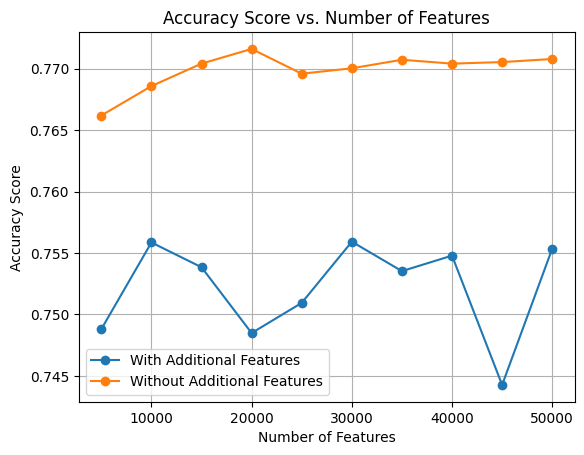

In [41]:
#Accuracy with/wothout own features

import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Create CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define values for n_features
n_features = np.arange(5000, 50001, 5000)

# Create lists to store accuracy scores
accuracy_with_features = []
accuracy_without_features = []

# Loop through different values of n_features
for n in n_features:
    
    # Create CountVectorizer with max_features=n
    cvec = CountVectorizer(max_features=n)

    # Vectorize the string data without additional features
    X_train_matrix = cvec.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix = cvec.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions without additional features
    lr.fit(X_train_matrix, y_train)
    y_pred_without_features = lr.predict(X_test_matrix)
    accuracy_without = accuracy_score(y_test, y_pred_without_features)
    accuracy_without_features.append(accuracy_without)

    # Vectorize the string data with additional features
    cvec_with_features = CountVectorizer(max_features=n)
    X_train_matrix_with_features = cvec_with_features.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_with_features = cvec_with_features.transform(X_test['tweet_tokenized_string'])

    # Combine the additional features with the vectorized data
    X_train_combined = hstack([X_train_matrix_with_features, add_features_train])
    X_test_combined = hstack([X_test_matrix_with_features, add_features_test])

    # Fit the model and make predictions with additional features
    lr.fit(X_train_combined, y_train)
    y_pred_with_features = lr.predict(X_test_combined)
    accuracy_with = accuracy_score(y_test, y_pred_with_features)
    accuracy_with_features.append(accuracy_with)

    

# Plot the accuracy scores
plt.plot(n_features, accuracy_with_features, 'o-', label='With Additional Features')
plt.plot(n_features, accuracy_without_features, 'o-', label='Without Additional Features')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score vs. Number of Features')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

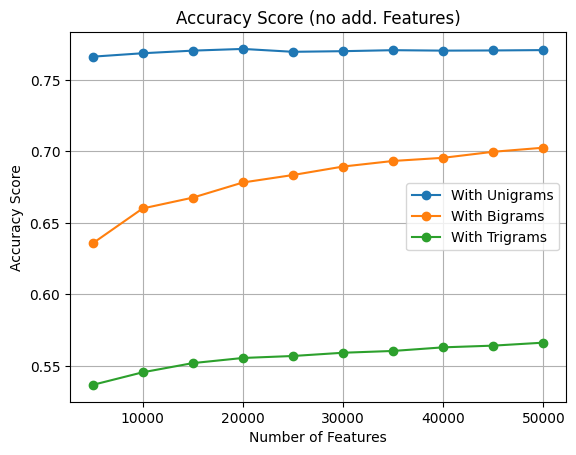

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Create CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define different values for n_features
n_features = np.arange(5000, 50001, 5000)

# Create lists to store n_features and accuracy scores for plot
n_features_list = []
accuracy_unigrams = []
accuracy_bigrams = []
accuracy_trigrams = []

# Loop through different values of n_features
for n in n_features:
   
    ### UNIGRAMS ###
    # Create CountVectorizer with max_features=n for unigrams
    cvec_unigrams = CountVectorizer(max_features=n, ngram_range=(1, 1))

    # Vectorize the string data for unigrams
    X_train_matrix_unigrams = cvec_unigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unigrams = cvec_unigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unigrams
    lr.fit(X_train_matrix_unigrams, y_train)
    y_pred_unigrams = lr.predict(X_test_matrix_unigrams)
    accuracy_unigram = accuracy_score(y_test, y_pred_unigrams)
    accuracy_unigrams.append(accuracy_unigram)

    ### BIGRAMS ###
    # Create CountVectorizer with max_features=n for bigrams
    cvec_bigrams = CountVectorizer(max_features=n, ngram_range=(2, 2))

    # Vectorize the string data for bigrams
    X_train_matrix_bigrams = cvec_bigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_bigrams = cvec_bigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for bigrams
    lr.fit(X_train_matrix_bigrams, y_train)
    y_pred_bigrams = lr.predict(X_test_matrix_bigrams)
    accuracy_bigram = accuracy_score(y_test, y_pred_bigrams)
    accuracy_bigrams.append(accuracy_bigram)
    
    ### TRIGRAMS ###
    # Create CountVectorizer with max_features=n for trigrams
    cvec_trigrams = CountVectorizer(max_features=n, ngram_range=(3, 3))

    # Vectorize the string data for trigrams
    X_train_matrix_trigrams = cvec_trigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_trigrams = cvec_trigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for trigrams
    lr.fit(X_train_matrix_trigrams, y_train)
    y_pred_trigrams = lr.predict(X_test_matrix_trigrams)
    accuracy_trigram = accuracy_score(y_test, y_pred_trigrams)
    accuracy_trigrams.append(accuracy_trigram)

# Plot the accuracy scores
plt.plot(n_features, accuracy_unigrams, 'o-', label='With Unigrams')
plt.plot(n_features, accuracy_bigrams, 'o-', label='With Bigrams')
plt.plot(n_features, accuracy_trigrams, 'o-', label='With Trigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score (no add. Features)')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

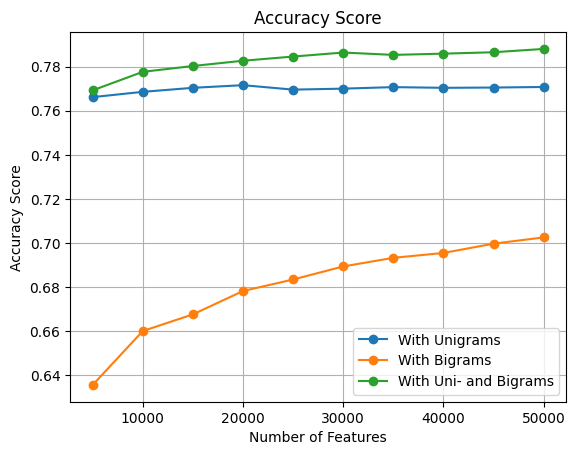

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Initialize CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define different values for n_features
n_features = np.arange(5000, 50001, 5000)

# Initialize lists to store n_features and accuracy scores
n_features_list = []
accuracy_unigrams = []
accuracy_bigrams = []
accuracy_unibigrams = []

# Loop through different values of n_features
for n in n_features:
   
    # Initialize CountVectorizer with max_features=n for unigrams
    cvec_unigrams = CountVectorizer(max_features=n, ngram_range=(1, 1))

    # Vectorize the string data for unigrams
    X_train_matrix_unigrams = cvec_unigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unigrams = cvec_unigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unigrams
    lr.fit(X_train_matrix_unigrams, y_train)
    y_pred_unigrams = lr.predict(X_test_matrix_unigrams)
    accuracy_unigram = accuracy_score(y_test, y_pred_unigrams)
    accuracy_unigrams.append(accuracy_unigram)

    # Initialize CountVectorizer with max_features=n for bigrams
    cvec_bigrams = CountVectorizer(max_features=n, ngram_range=(2, 2))

    # Vectorize the string data for bigrams
    X_train_matrix_bigrams = cvec_bigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_bigrams = cvec_bigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for bigrams
    lr.fit(X_train_matrix_bigrams, y_train)
    y_pred_bigrams = lr.predict(X_test_matrix_bigrams)
    accuracy_bigram = accuracy_score(y_test, y_pred_bigrams)
    accuracy_bigrams.append(accuracy_bigram)

    # Initialize CountVectorizer with max_features=n for unibigrams
    cvec_unibigrams = CountVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = cvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = cvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    lr.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = lr.predict(X_test_matrix_unibigrams)
    accuracy_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_unibigrams.append(accuracy_unibigram)

# Plot the accuracy scores
plt.plot(n_features, accuracy_unigrams, 'o-', label='With Unigrams')
plt.plot(n_features, accuracy_bigrams, 'o-', label='With Bigrams')
plt.plot(n_features, accuracy_unibigrams, 'o-', label='With Uni- and Bigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\del-f\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stab

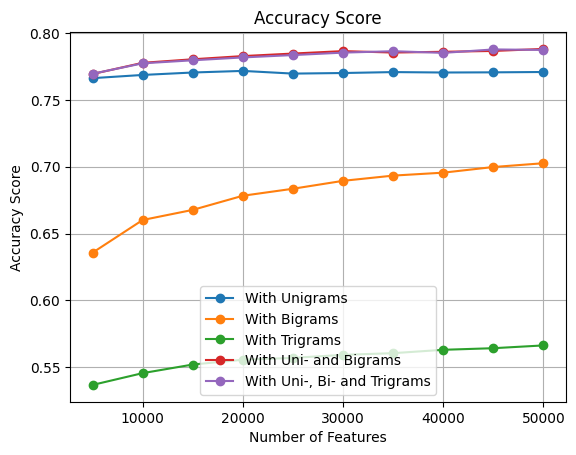

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.sparse import hstack

# Initialize CountVectorizer and LogisticRegression
cvec = CountVectorizer()
lr = LogisticRegression(random_state=42)

# Define different values for n_features
n_features = np.arange(5000, 50001, 5000)

# Initialize lists to store n_features and accuracy scores
n_features_list = []
accuracy_unigrams = []
accuracy_bigrams = []
accuracy_trigrams = []
accuracy_unibigrams = []
accuracy_unibitrigrams = []

# Loop through different values of n_features
for n in n_features:
   
    ### UNIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unigrams
    cvec_unigrams = CountVectorizer(max_features=n, ngram_range=(1, 1))

    # Vectorize the string data for unigrams
    X_train_matrix_unigrams = cvec_unigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unigrams = cvec_unigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unigrams
    lr.fit(X_train_matrix_unigrams, y_train)
    y_pred_unigrams = lr.predict(X_test_matrix_unigrams)
    accuracy_unigram = accuracy_score(y_test, y_pred_unigrams)
    accuracy_unigrams.append(accuracy_unigram)

    ### BIGRAMS ###
    # Initialize CountVectorizer with max_features=n for bigrams
    cvec_bigrams = CountVectorizer(max_features=n, ngram_range=(2, 2))

    # Vectorize the string data for bigrams
    X_train_matrix_bigrams = cvec_bigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_bigrams = cvec_bigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for bigrams
    lr.fit(X_train_matrix_bigrams, y_train)
    y_pred_bigrams = lr.predict(X_test_matrix_bigrams)
    accuracy_bigram = accuracy_score(y_test, y_pred_bigrams)
    accuracy_bigrams.append(accuracy_bigram)

    ### TRIGRAMS ###
    # Create CountVectorizer with max_features=n for trigrams
    cvec_trigrams = CountVectorizer(max_features=n, ngram_range=(3, 3))

    # Vectorize the string data for trigrams
    X_train_matrix_trigrams = cvec_trigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_trigrams = cvec_trigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for trigrams
    lr.fit(X_train_matrix_trigrams, y_train)
    y_pred_trigrams = lr.predict(X_test_matrix_trigrams)
    accuracy_trigram = accuracy_score(y_test, y_pred_trigrams)
    accuracy_trigrams.append(accuracy_trigram)

    ### UNIBIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibigrams
    cvec_unibigrams = CountVectorizer(max_features=n, ngram_range=(1, 2))

    # Vectorize the string data for unibigrams
    X_train_matrix_unibigrams = cvec_unibigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibigrams = cvec_unibigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibigrams
    lr.fit(X_train_matrix_unibigrams, y_train)
    y_pred_unibigrams = lr.predict(X_test_matrix_unibigrams)
    accuracy_unibigram = accuracy_score(y_test, y_pred_unibigrams)
    accuracy_unibigrams.append(accuracy_unibigram)
    
    ### UNIBITRIGRAMS ###
    # Initialize CountVectorizer with max_features=n for unibitrigrams
    cvec_unibitrigrams = CountVectorizer(max_features=n, ngram_range=(1, 3))

    # Vectorize the string data for unibitrigrams
    X_train_matrix_unibitrigrams = cvec_unibitrigrams.fit_transform(X_train['tweet_tokenized_string'])
    X_test_matrix_unibitrigrams = cvec_unibitrigrams.transform(X_test['tweet_tokenized_string'])

    # Fit the model and make predictions for unibitrigrams
    lr.fit(X_train_matrix_unibitrigrams, y_train)
    y_pred_unibitrigrams = lr.predict(X_test_matrix_unibitrigrams)
    accuracy_unibitrigram = accuracy_score(y_test, y_pred_unibitrigrams)
    accuracy_unibitrigrams.append(accuracy_unibitrigram)

# Plot the accuracy scores
plt.plot(n_features, accuracy_unigrams, 'o-', label='With Unigrams')
plt.plot(n_features, accuracy_bigrams, 'o-', label='With Bigrams')
plt.plot(n_features, accuracy_trigrams, 'o-', label='With Trigrams')
plt.plot(n_features, accuracy_unibigrams, 'o-', label='With Uni- and Bigrams')
plt.plot(n_features, accuracy_unibitrigrams, 'o-', label='With Uni-, Bi- and Trigrams')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Score')
plt.legend()
plt.grid(True)
plt.show()

#### Ab hier im neuen Notebook weiterarbeiten

Train test split

In [ ]:
model_data = data[['sentiment', 'year', 'month', 'weekday', 'hour', 'word_count', 'dot_dot_dot', 'exclamation_mark', 'question_mark', 'at_symbol', 'link', 'money', 'paragraph_symbol', 'hashtag', 'tweet_tokenized_string']]
model_data.head(2)
X = model_data.drop(columns='sentiment')
y = model_data['sentiment']

In [ ]:
# Vectorizen mit allen Daten damit wir eine Matrix haben die alle Wörter enthält - Für das neuronale Netz müssen train und test Daten die gleichen Spalten enthalten. Sonst gibt es ein Problem bei Wörtern die nur in einem Split vorkommen. 
# Wir wollen das lösen indem wir eine Matrix aus dem gesamten Datensatz, also mit allen Wörtern, erstellen. Die Zeilen in diesen dann zu löschen und mit einer aus den Train Daten neu erstellten Matrix ersetzen. 

# Matrix aus allen Daten (Alle Wörter)

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer() #Create a vectorizer that weighs the count of each token by its frequency in the dataset
X_vect_matrix = tfidf_vect.fit_transform(X['tweet_tokenized_string']) #Create a matrix with the tfidf score of each token in each tweet
print(X_vect_matrix.shape)
print(tfidf_vect.get_feature_names_out())

(1587566, 51602)
['aa' 'aaa' 'aaaa' ... 'ùù' 'ùùù' 'ùùùù']


In [ ]:
# Versuch die Zeilen der Matrix zu löschen aber die Spalten zu behalten. Hat aber nicht funktioniert. Wir wissen nicht ob die Spaltennamen in der sparse Matrix stehen.
#Wenn das nicht der Fall wäre ist die Zuordnung der neuen Matrix zu der Matrix mit allen Wörtern schwierig

# Delete all columns
X_vect_matrix = X_vect_matrix.tocsc()  # Convert to CSC format for efficient column deletion
X_vect_matrix = X_vect_matrix[:, :]
X_vect_matrix

<1587565x51602 sparse matrix of type '<class 'numpy.float64'>'
	with 10367400 stored elements in Compressed Sparse Column format>

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
#Hier würden wir eine neue Matrix aus den Train Daten erstellen um die Values dann in die Matrix mit allen Wörtern einfügen.
X_train_vect_matrix_new = tfidf_vect.transform(X_train)
from scipy.sparse import csr_matrix
zero_matrix = csr_matrix(X_train_vect_matrix_new.shape, dtype=np.float64)
index_array = np.arange(X_train_vect_matrix.shape[0])

# Align the shapes of the matrices and assign values
zero_matrix[np.ix_(index_array[X_train.index], np.arange(X_train_vect_matrix.shape[1]))] = X_train_vect_matrix_new

# Print the shape and feature names of the new matrix
print(zero_matrix.shape)
print(tfidf_vect.get_feature_names_out())


AttributeError: lower not found

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer() #Create a vectorizer that weighs the count of each token by its frequency in the dataset
X_train_vect_matrix = tfidf_vect.fit_transform(X_train['tweet_tokenized_string']) #Create a matrix with the tfidf score of each token in each tweet
print(X_train_vect_matrix.shape)
print(tfidf_vect.get_feature_names_out())

(1063669, 51551)
['aa' 'aaa' 'aaaa' ... 'ùøùùù' 'ùù' 'ùùù']


In [90]:
# So können wir später unsere erstellten Features an die Matrix anhängen - Einmal für die Train und die Test Matrix
import scipy
from scipy.sparse import hstack

additional_features_train = X_train[['year',
                            'month',
                            'weekday',
                            'hour',
                            'word_count',
                            'dot_dot_dot',
                            'exclamation_mark',
                            'question_mark',
                            'at_symbol',
                            'link',
                            'money',
                            'paragraph_symbol',
                            'hashtag'
                            ]]

# We convert the additional_features dataframe to a sparse matrix
additional_features_train_matrix = scipy.sparse.csr_matrix(additional_features_train.values)

# Then we horizontally stack the tf-idf matrix with the additional features
X_train_matrix = hstack([X_train_vect_matrix, additional_features_train_matrix])


In [91]:
print("Original tf-idf matrix shape:", X_train_vect_matrix.shape)
print("Combined matrix shape:", X_train_matrix.shape)


Original tf-idf matrix shape: (1063669, 51551)
Combined matrix shape: (1063669, 51564)


In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer() #Create a vectorizer that weighs the count of each token by its frequency in the dataset
X_test_vect_matrix = tfidf_vect.fit_transform(X_test['tweet_tokenized_string']) #Create a matrix with the tfidf score of each token in each tweet
print(X_test_vect_matrix.shape)
print(tfidf_vect.get_feature_names_out())

(523897, 49645)
['aa' 'aaa' 'aaaa' ... 'ùù' 'ùùù' 'ùùùù']


In [95]:
import scipy
from scipy.sparse import hstack

additional_features_test = X_test[['year',
                            'month',
                            'weekday',
                            'hour',
                            'word_count',
                            'dot_dot_dot',
                            'exclamation_mark',
                            'question_mark',
                            'at_symbol',
                            'link',
                            'money',
                            'paragraph_symbol',
                            'hashtag'
                            ]]

# We convert the additional_features dataframe to a sparse matrix
additional_features_test_matrix = scipy.sparse.csr_matrix(additional_features_test.values)

# Then we horizontally stack the tf-idf matrix with the additional features
X_test_matrix = hstack([X_test_vect_matrix, additional_features_test_matrix])


In [96]:
print("Original tf-idf matrix shape:", X_test_vect_matrix.shape)
print("Combined matrix shape:", X_test_matrix.shape)


Original tf-idf matrix shape: (523897, 49645)
Combined matrix shape: (523897, 49658)


In [100]:
X_test_matrix.shape[1]

49658

In [ ]:
#pip install tensorflow

In [112]:
from keras.models import Sequential
from keras.layers import Dense

# assuming your input data has 100000 features
input_dim = X_train_matrix.shape[1]

model = Sequential()
model.add(Dense(256, input_dim=input_dim, activation='relu'))  # Hidden layer 1
model.add(Dense(128, activation='relu'))  # Hidden layer 2
model.add(Dense(64, activation='relu'))  # Hidden layer 3
model.add(Dense(1, activation='sigmoid'))  # Output layer

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [115]:
neural_network = model.fit(X_train_matrix, y_train, epochs=10, batch_size=64) #validation_data=(X_test_matrix, y_test))

InvalidArgumentError: {{function_node __wrapped__SerializeManySparse_device_/job:localhost/replica:0/task:0/device:CPU:0}} indices[2] = [0,25425] is out of order. Many sparse ops require sorted indices.
    Use `tf.sparse.reorder` to create a correctly ordered copy.

 [Op:SerializeManySparse]

### Vectorizing first

Uni/Bigram

In [24]:
data

,sentiment,id,user,tweet,tweet_tokenized,date,year,month,weekday,time,...,word_count,dot_dot_dot,exclamation_mark,question_mark,at_symbol,link,money,paragraph_symbol,hashtag,tweet_tokenized_string
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[awww, thats, bummer, shoulda, got, david, car...",2009-04-06 22:19:45,2009,4,0,22:19:45,...,19,False,False,False,True,True,False,False,False,awww thats bummer shoulda got david carr third...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by ...,"[upset, cant, update, facebook, texting, might...",2009-04-06 22:19:49,2009,4,0,22:19:49,...,21,True,True,False,False,False,False,False,False,upset cant update facebook texting might cry r...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Man...,"[many, time, ball, managed, save, rest, go, bo...",2009-04-06 22:19:53,2009,4,0,22:19:53,...,18,False,False,False,True,False,False,False,False,many time ball managed save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,10,False,False,False,False,False,False,False,False,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all....","[behaving, im, mad, cant, see]",2009-04-06 22:19:57,2009,4,0,22:19:57,...,21,False,False,True,True,False,False,False,False,behaving im mad cant see
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599995,1,2193601966,AmandaMarie1028,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,False,False,False,False,False,False,False,False,woke school best feeling ever
1599996,1,2193601969,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,"[cool, hear, old, walt, interview, â]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,False,True,False,False,True,False,False,False,cool hear old walt interview â
1599997,1,2193601991,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,11,False,False,True,False,False,False,False,False,ready mojo makeover ask detail
1599998,1,2193602064,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, th, birthday, boo, alll, time, tupac]",2009-06-16 08:40:49,2009,6,1,08:40:49,...,12,False,True,False,False,False,False,False,False,happy th birthday boo alll time tupac


In [25]:
from sklearn.feature_extraction.text import CountVectorizer

ngram_vect = CountVectorizer(ngram_range=(1,2)) #Create a vectorizer that creates unigrams and bigrams from our tweets
ngram_matrix = ngram_vect.fit_transform(data['tweet_tokenized_string']) #Create a matrix with the counts of each unigram and bigram in each tweet
print(ngram_matrix.shape) #Print the shape of the matrix


(1587566, 3395516)


In [26]:
ngram_matrix

<1587566x3395516 sparse matrix of type '<class 'numpy.int64'>'
	with 19376522 stored elements in Compressed Sparse Row format>

In [27]:
#Look at a sample of the created ngram matrix to see how it looks like
ngram_matrix_sample = ngram_matrix[:10, :10]
feature_names = ngram_vect.get_feature_names_out()[:10]
ngram_matrix_sample = ngram_matrix_sample.toarray()
ngram_matrix_sample_df = pd.DataFrame(ngram_matrix_sample, columns=feature_names)
print(ngram_matrix_sample_df)

   aa  aa allstars  aa already  aa amp  aa arrive  aa ba  aa bachelor  aa bad  \
0   0            0           0       0          0      0            0       0   
1   0            0           0       0          0      0            0       0   
2   0            0           0       0          0      0            0       0   
3   0            0           0       0          0      0            0       0   
4   0            0           0       0          0      0            0       0   
5   0            0           0       0          0      0            0       0   
6   0            0           0       0          0      0            0       0   
7   0            0           0       0          0      0            0       0   
8   0            0           0       0          0      0            0       0   
9   0            0           0       0          0      0            0       0   

   aa baseball  aa battery  
0            0           0  
1            0           0  
2            0       

In [28]:
print(ngram_vect.get_feature_names_out()) #Print the names of the unigrams and bigrams


['aa' 'aa allstars' 'aa already' ... 'ùùù ùù' 'ùùùù' 'ùùùù gtlt']


Tfidf

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer() #Create a vectorizer that weighs the count of each token by its frequency in the dataset
tfidf_matrix = tfidf_vect.fit_transform(data['tweet_tokenized_string']) #Create a matrix with the tfidf score of each token in each tweet
print(tfidf_matrix.shape)
print(tfidf_vect.get_feature_names_out())

(1587566, 51602)
['aa' 'aaa' 'aaaa' ... 'ùù' 'ùùù' 'ùùùù']


In [30]:
#Look at a sample of the created tdidf matrix to see how it looks like
tfidf_matrix_sample = tfidf_matrix[:10, :10]
feature_names = tfidf_vect.get_feature_names_out()[:10]
tfidf_matrix_sample = tfidf_matrix_sample.toarray()
tfidf_matrix_sample_df = pd.DataFrame(tfidf_matrix_sample, columns=feature_names)
print(tfidf_matrix_sample_df)

    aa  aaa  aaaa  aaaaa  aaaaaa  aaaaaaa  aaaaaaaa  aaaaaaaaa  aaaaaaaaaa  \
0  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
1  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
2  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
3  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
4  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
5  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
6  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
7  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
8  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   
9  0.0  0.0   0.0    0.0     0.0      0.0       0.0        0.0         0.0   

   aaaaaaaaaaaaa  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  
5            0.0  
6       

In [32]:
#%pip install scipy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Dave\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [54]:
import scipy
from scipy.sparse import hstack

# Suppose df['contains_exclamation'] and df['num_words'] are your additional features
additional_features = data[['sentiment',
                            'year',
                            'month',
                            'weekday',
                            'hour',
                            'word_count',
                            'dot_dot_dot',
                            'exclamation_mark',
                            'question_mark',
                            'at_symbol',
                            'link',
                            'money',
                            'paragraph_symbol',
                            'hashtag'
                            ]]

# We convert the additional_features dataframe to a sparse matrix
additional_features_sparse = scipy.sparse.csr_matrix(additional_features.values)

# Then we horizontally stack the tf-idf matrix with the additional features
X_combined = hstack([tfidf_matrix, additional_features_sparse])


In [57]:
print("Original tf-idf matrix shape:", tfidf_matrix.shape)
print("Combined matrix shape:", X_combined.shape)


Original tf-idf matrix shape: (1587566, 51602)
Combined matrix shape: (1587566, 51616)
